In [2]:
from ultralytics import YOLO
from pathlib import Path
from torchvision import transforms
from PIL import Image
import pandas as pd

root_dir = Path("../downloaded_images/train").resolve()

model = YOLO("../models/scrap174.pt")

# Recursively find all image files in the directory
image_paths = list(root_dir.rglob('*.jpg')) + list(root_dir.rglob('*.png'))

transform = transforms.Compose([
    transforms.Resize((640,640)),  # Resize the image
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
])

data = []

for path in image_paths:
    image = Image.open(path)
    image = image.convert('RGB')
    image = transform(image).unsqueeze(0)  
    result = model(image)
    
    true_class = path.parent.name
    names = result[0].names
    probs = result[0].probs.top5
    conf = result[0].probs.top5conf.tolist()
    # Append the data to the list
    data.append([str(path), true_class, names[probs[0]], conf])

# Convert the list to a pandas DataFrame
df = pd.DataFrame(data, columns=['image_path', 'true_class', 'predict_class', 'conf'])
df = df.sort_values('conf')
lowest_conf_df = df.head()

c:\Users\santy\anaconda3\envs\torchgpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



0: 640x640 Aguachile 1.00, Ceviche 0.00, Ceviche peruano 0.00, Greek salad 0.00, Shrimp and grits 0.00, 24.2ms
Speed: 1.0ms preprocess, 24.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 Aguachile 0.98, Carpaccio 0.01, Zucchini noodles 0.00, Risotto 0.00, Ceviche 0.00, 22.0ms
Speed: 0.0ms preprocess, 22.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 Aguachile 1.00, Souvlaki 0.00, Greek salad 0.00, Ceviche 0.00, Gazpacho 0.00, 20.4ms
Speed: 0.0ms preprocess, 20.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 Aguachile 0.42, Huevos rancheros 0.14, Tostadas de tinga 0.12, Cochinita pibil 0.11, Carnitas 0.04, 30.9ms
Speed: 0.0ms preprocess, 30.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 Aguachile 1.00, Bagel and lox 0.00, Ceviche 0.00, Greek salad 0.00, Ceviche peruano 0.00, 31.2ms
Speed: 0.0ms preprocess, 31.2ms inference, 0.0ms postprocess per image at

In [3]:
import torch
import torch.nn.functional as F
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer

# Load the model and tokenizer
model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-B-16-SigLIP')
tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')

c:\Users\santy\anaconda3\envs\torchgpu\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


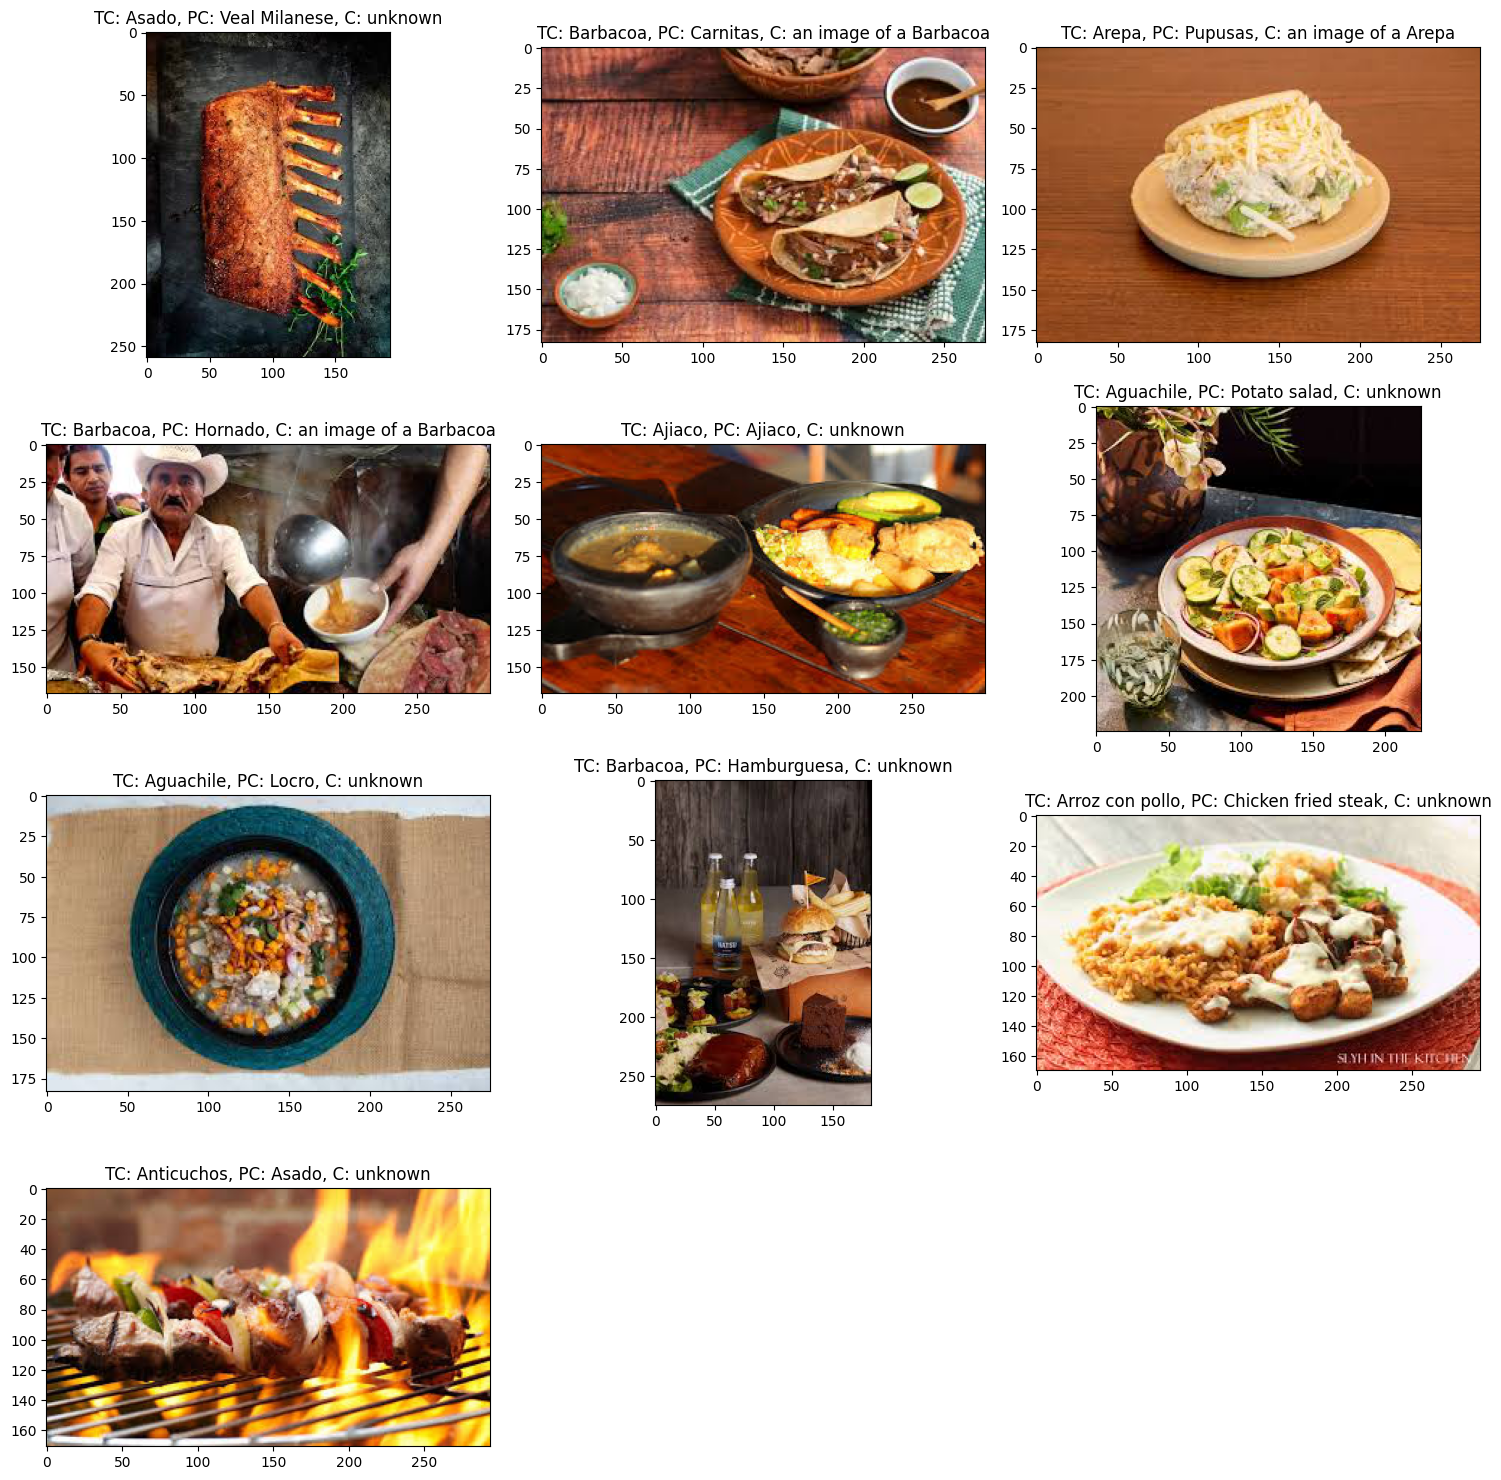

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

num_images = 10
# Determine the number of rows and columns for the grid
num_images = len(df[:num_images])
num_cols = 3  # You can change this to fit your needs
num_rows = num_images // num_cols if num_images % num_cols == 0 else num_images // num_cols + 1

# Create a figure and axes for the grid
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Iterate over the DataFrame and display the images
for i, (index, row) in enumerate(df[:num_images].iterrows()):
    img = mpimg.imread(row['image_path'])
    image = preprocess(Image.open(row['image_path'])).unsqueeze(0)

    labels_list = [f"an image of a {row['true_class']}"]
    text = tokenizer(labels_list, context_length=model.context_length)

    # Perform inference
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        image_features = F.normalize(image_features, dim=-1)
        text_features = F.normalize(text_features, dim=-1)

        # Calculate similarities and apply sigmoid to get probabilities
        text_probs = torch.sigmoid(image_features @ text_features.T * model.logit_scale.exp() + model.logit_bias)

    # Extract probabilities and print them
    probabilities = [round(p.item(), 3) for p in text_probs[0]]
    zipped_list = list(zip(labels_list, probabilities))

    # Decision based on the highest probability
    predicted_label = labels_list[probabilities.index(max(probabilities))]
    if probabilities[0] < 0.5:
        predicted_label = "unknown"
    
    ax = axs[i // num_cols, i % num_cols]
    ax.imshow(img)
    ax.set_title(f"TC: {row['true_class']}, PC: {row['predict_class']}, C: {predicted_label}")

# Remove empty subplots
if num_images % num_cols != 0:
    for ax in axs.flatten()[num_images:]:
        fig.delaxes(ax)

plt.tight_layout()
plt.show()